# GWR

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import datetime
from sklearn.preprocessing import StandardScaler
from esda.moran import Moran
from libpysal.weights import Queen
from libpysal.weights import KNN

In [2]:
# Loading MSOA boundary data
msoa_boundary = gpd.read_file('MSOA_2011_London_gen_MHW.shp')
msoa_boundary = msoa_boundary.to_crs(epsg=27700)  # 转换坐标系到英国国家网格

In [3]:
# Loading night site data
nighttime_stops_msoa = pd.read_csv('MSOA_nighttime_stops.csv')
# Load demographic data and rename columns
msoa_population = pd.read_csv('msoa-data.csv', encoding='ISO-8859-1')
msoa_population.rename(columns={'Middle Super Output Area': 'MSOA11CD'}, inplace=True)

In [4]:
# Calculate the area of each MSOA region (square kilometres)
msoa_boundary['area_sq_km'] = msoa_boundary.area / 1e6

In [5]:
# Consolidation of night site data
msoa_boundary = msoa_boundary.merge(nighttime_stops_msoa, on='MSOA11CD', how='left')
msoa_boundary['NUMPOINTS'].fillna(0, inplace=True)

# Calculate site density
msoa_boundary['stop_density_per_sq_km'] = msoa_boundary['NUMPOINTS'] / msoa_boundary['area_sq_km']

In [6]:
# Consolidation of population data
msoa_boundary = msoa_boundary.merge(msoa_population[['MSOA11CD', 'Age Structure (2011 Census);All Ages;']], 
                                    on='MSOA11CD', how='left')

# Calculation of population density
msoa_boundary['population_density'] = msoa_boundary['Age Structure (2011 Census);All Ages;'] / msoa_boundary['area_sq_km']

In [7]:
# Define functions to handle non-standard time formats
def handle_nonstandard_times(time_str):
    if time_str:
        hours, minutes, seconds = map(int, time_str.split(':'))
        if hours >= 24:  
            hours -= 24
        return datetime.time(hours, minutes, seconds)
    return None

# Load site frequency data
stop_times_df = pd.read_csv('stop_times.txt')
stops_df = pd.read_csv('stops.txt')

In [8]:
# Applying time processing functions
stop_times_df['arrival_time'] = stop_times_df['arrival_time'].apply(handle_nonstandard_times)

# Filtering of data for night-time hours (11 p.m. to 5 a.m.)
nighttime_stop_times = stop_times_df[stop_times_df['arrival_time'].apply(lambda x: datetime.time(23, 0) <= x or x <= datetime.time(5, 0))]

In [9]:
# Calculate the frequency of night service at each site
nighttime_frequency = nighttime_stop_times.groupby('stop_id').size().reset_index(name='nighttime_frequency')

In [10]:
# Consolidation of night service frequencies into site data
stops_gdf = gpd.GeoDataFrame(
    stops_df,
    geometry=gpd.points_from_xy(stops_df['stop_lon'], stops_df['stop_lat']),
    crs='EPSG:4326'
)
stops_gdf = stops_gdf.merge(nighttime_frequency, on='stop_id', how='left')

# Convert the coordinate system of stops_gdf to EPSG:27700 to match msoa_boundary
stops_gdf = stops_gdf.to_crs(epsg=27700)

# Spatial linking of site data to MSOA boundary data
stops_with_msoa = gpd.sjoin(stops_gdf, msoa_boundary, how='left', predicate='within')

In [11]:
# Calculate the average night service frequency for each MSOA region
average_frequency_per_msoa = stops_with_msoa.groupby('MSOA11CD')['nighttime_frequency'].mean().reset_index()
msoa_boundary = msoa_boundary.merge(average_frequency_per_msoa, on='MSOA11CD', how='left')
msoa_boundary['nighttime_frequency'].fillna(0, inplace=True)

In [12]:
# Data standardisation
scaler = StandardScaler()
columns_to_scale = ['stop_density_per_sq_km', 'nighttime_frequency', 'population_density']
msoa_boundary[columns_to_scale] = scaler.fit_transform(msoa_boundary[columns_to_scale])

In [13]:
# Construction of spatial weight matrix based on K-nearest neighbours
k = 5
w_knn = KNN.from_dataframe(msoa_boundary, k=k)

In [15]:
# Using the new weight matrix to calculate Moran's I
moran_density_knn = Moran(msoa_boundary['stop_density_per_sq_km'], w_knn)
print(f"Moran's I for Stop Density (KNN): {moran_density_knn.I}, p-value: {moran_density_knn.p_sim}")

Moran's I for Stop Density (KNN): 0.3911228623108659, p-value: 0.001


In [16]:
# Moran's I for calculating site frequency
moran_frequency_knn = Moran(msoa_boundary['nighttime_frequency'], w_knn)
print(f"Moran's I for Stop Frequency (KNN): {moran_frequency_knn.I}, p-value: {moran_frequency_knn.p_sim}")

Moran's I for Stop Frequency (KNN): 0.5055719097666419, p-value: 0.001


In [17]:
# Moran's I for calculating population density
moran_population_knn = Moran(msoa_boundary['population_density'], w_knn)
print(f"Moran's I for Population Density (KNN): {moran_population_knn.I}, p-value: {moran_population_knn.p_sim}")

Moran's I for Population Density (KNN): 0.6745642054424638, p-value: 0.001


In [18]:
# Preparing data for the GWR model
X = msoa_boundary[['stop_density_per_sq_km', 'nighttime_frequency']].values
y = msoa_boundary['population_density'].values.reshape((-1, 1))

In [19]:
# Extract coordinates
u = msoa_boundary.centroid.x.values
v = msoa_boundary.centroid.y.values
coords = np.hstack((u[:, np.newaxis], v[:, np.newaxis]))

In [20]:
# Selecting the optimal bandwidth
bw = Sel_BW(coords, y, X, kernel='bisquare', fixed=False)
bw = bw.search()

# Create and fit a GWR model
gwr_model = GWR(coords, y, X, bw, kernel='bisquare', fixed=False)
gwr_results = gwr_model.fit()

# output result
print(gwr_results.summary())

Model type                                                         Gaussian
Number of observations:                                                 983
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                            578.701
Log-likelihood:                                                   -1134.409
AIC:                                                               2274.817
AICc:                                                              2276.858
BIC:                                                              -6174.096
R2:                                                                   0.411
Adj. R2:                                                              0.410

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

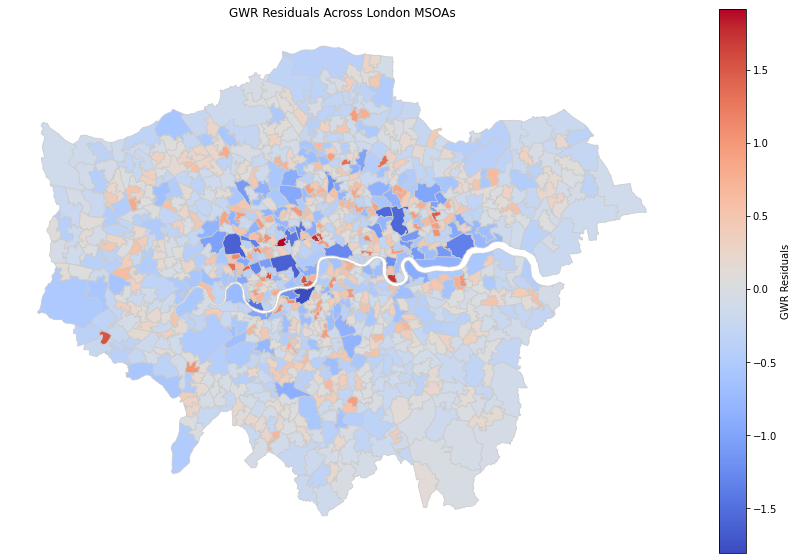

In [23]:
# Adding GWR residuals to msoa_boundary GeoDataFrame
msoa_boundary['gwr_residuals'] = gwr_results.resid_response.flatten()

# Visualising the distribution of GWR residuals on MSOA boundaries
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
msoa_boundary.plot(column='gwr_residuals', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8')

# Add Legend
sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=msoa_boundary['gwr_residuals'].min(), vmax=msoa_boundary['gwr_residuals'].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('GWR Residuals')

# Add title and notes
ax.set_title('GWR Residuals Across London MSOAs')
ax.axis('off')

plt.show()